In [1]:
%matplotlib inline
import numpy as np
import healpy as hp

import matplotlib.pyplot as plt
from IPython.display import display, Math
import zeus
from modules import (init_cosmology, init_sample, PNGModel,
                     Posterior, read_mocks, WindowSHT, read_weight_mask)

In [25]:
# --- theory
cosmo = init_cosmology()
z, b, dNdz = init_sample()
model = PNGModel(cosmo, has_fnl=True, has_rsd=True)
model.add_tracer(z, b, dNdz)

# --- 'Data'
x, y, invcov, cov = read_mocks('masked', return_cov=True)
weight, mask = read_weight_mask()

NOTE: This code uses a cosmology calculator that returns k and P(k) in units of 1/Mpc and Mpc^3.
 Therefore, the coefficient alpha in the model uses H_0 = 100h, not H_0=100.
bins: [  3   5   7   9  11  13  15  17  19  26  48  96 192 384]


/Users/rezaie/anaconda3/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(


In [26]:
x_g = np.arange(768)
wd = WindowSHT(weight, mask, x_g)

def modelw(ell, fnl):
    cl_null = model(ell, fnl)
    return wd.convolve(cl_null)

lmax: 767


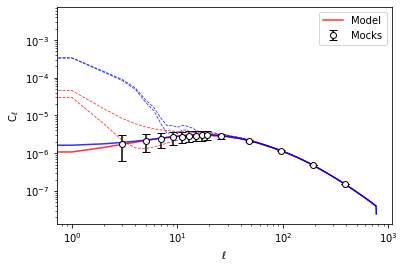

In [28]:
# plot
plt.errorbar(x, y, yerr=np.diag(cov)**0.5, 
             ls='none', color='k', marker='o', mfc='w', capsize=4, 
             label='Mocks')

plt.plot(x_g, model(x_g, 0), 'r-', label='Model', alpha=0.8)
plt.plot(x_g, model(x_g, 100.), 'r--', alpha=0.8, lw=0.8)
plt.plot(x_g, model(x_g, -100.), 'r--', alpha=0.8, lw=0.8)
plt.plot(x_g, modelw(x_g, 0), 'b-', alpha=0.8)
plt.plot(x_g, modelw(x_g, 100.), 'b--', alpha=0.8, lw=0.8)
plt.plot(x_g, modelw(x_g, -100.), 'b--', alpha=0.8, lw=0.8)

plt.loglog()
plt.legend()
plt.xlabel(r'$\ell$')
plt.ylabel('C$_{\ell}$')
plt.savefig('mocks_model.png', dpi=300, bbox_inches='tight')

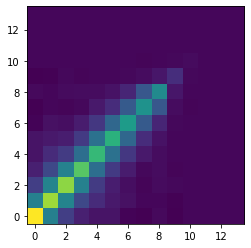

In [5]:
plt.imshow(cov, origin='lower')

In [6]:
wd = WindowSHT(weight, mask, x)
ell_ = np.arange(768)

def modelw(ell, fnl):
    cl_null = model(ell_, fnl)
    return wd.convolve(cl_null)

lg = Posterior(modelw)

lmax: 767


In [7]:
for fNL in [-999, -500, -100, -10, 0, 10, 100, 500, 999]:
    print(fNL, lg.logpost(fNL, y, invcov, x))

-999 -28017132.671119623
-500 -1747622.0276246534
-100 -2678.6896703493853
-10 -4.274916677958705
0 -4.064843248916713
10 -4.7945085298888
100 -3027.030321044985
500 -1790957.0317479686
999 -28362721.999468833


In [8]:
np.random.seed(42)

ndim = 1       # Number of parameters/dimensions (e.g. m and c)
nwalkers = 10  # Number of walkers to use. It should be at least twice the number of dimensions.
nsteps = 1000  # Number of steps/iterations.

start = 10. * np.random.randn(nwalkers, ndim) # Initial positions of the walkers.
print(f'initial guess: {start}')

sampler = zeus.EnsembleSampler(nwalkers, ndim, lg.logpost, args=[y, invcov, x], maxiter=100000)
sampler.run_mcmc(start, nsteps) # Run sampling
sampler.summary # Print summary diagnostics

Initialising ensemble of 10 walkers...


initial guess: [[ 4.96714153]
 [-1.38264301]
 [ 6.47688538]
 [15.23029856]
 [-2.34153375]
 [-2.34136957]
 [15.79212816]
 [ 7.67434729]
 [-4.69474386]
 [ 5.42560044]]


Sampling progress :   3%|▎         | 33/1000 [12:03<6:49:12, 25.39s/it]

KeyboardInterrupt: 

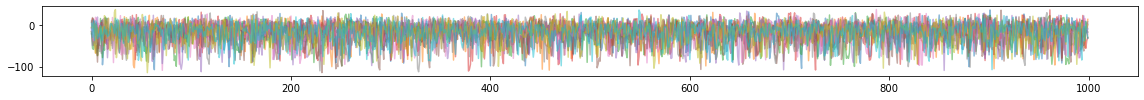

In [7]:
plt.figure(figsize=(16, 1.5*ndim))
for n in range(ndim):
    plt.subplot2grid((ndim, 1), (n, 0))
    plt.plot(sampler.get_chain()[:,:,0], alpha=0.5)
plt.tight_layout()
plt.show()

In [8]:
# flatten the chains, thin them by a factor of 15, 
# and remove the burn-in (first half of the chain)
chain = sampler.get_chain(flat=True, discard=20, thin=5)

In [9]:
np.save('chains_window.npy', chain)  # 

In [6]:
chainw = np.load('chains_window.npy', allow_pickle=True)
chain = np.load('chains.npy', allow_pickle=True)

In [9]:
bins = np.arange(-1000, 1000., 3.8*np.std(chain)/(chain.size)**(1./3)) #
bins[:10]

array([-1000.        ,  -992.43724517,  -984.87449034,  -977.31173551,
        -969.74898068,  -962.18622585,  -954.62347101,  -947.06071618,
        -939.49796135,  -931.93520652])

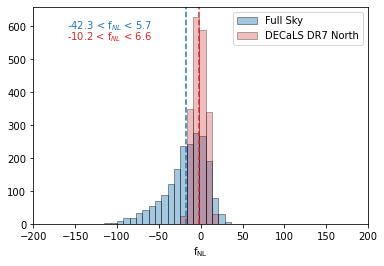

In [29]:
fg, ax = plt.subplots()

colors = ['C0', 'C3']
names = ['Full Sky', 'DECaLS DR7 North']

for i, chain_ in enumerate([chain, chainw]):
    
    _= ax.hist(chain_,
                bins=bins, alpha=0.4-i*0.1, edgecolor='k', color=colors[i],
              label=names[i])
    ax.axvline(np.mean(chain_), ls='--', color=colors[i])
    fmin, fmax = np.percentile(chain_, [15.7, 84.3])
    ax.text(0.1, 0.9-i*0.05, fr"{fmin:.1f} < f$_{'{NL}'}$ < {fmax:.1f}", 
            transform=ax.transAxes, color=colors[i])

ax.set(xlabel=r'f$_{\rm NL}$', xlim=(-200, 200))
ax.legend()
plt.savefig('fnl.png', dpi=300, bbox_inches='tight')

In [14]:
np.mean(chain)

-17.56812161234904

In [15]:
np.percentile(chain, [15.7, 84.3])

array([-42.30893137,   5.66338158])